## TIME Exercise 1 (with additions from 2&3)

Select 2-3 time series datasets: opendata.swiss, ec.europa.eu/Eurostat, Kaggle, etc.
Reflect on the data generation process:

• How was the data collected? Time interval, time range, etc.

• Which factors/laws influence the data?

• Which patterns do you expect to find?


Analysis:

• Explain and interpret the plots. How noisy is the data?

• Review patterns, do they match your expectations given your understanding of the DGP?

• Review outliers, interpret them, and match with corresponding real-world events when applicable.


In [14]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf

from utils import get_figure, time_plot, stationarity_tests
from data import get_electrocardiogram, get_apple_5y, get_france_death_rate_20y, get_switzerland_temperature

#### Walmart sales:

This dataset contains weekly sales for multiple stores and departments. 

How was the data collected:
Walmart’s point-of-sale system.
Time interval: Weekly aggregated sales.
Time range: ~2010–2012.
Granularity: Store–Department level.

Which factors influence the data:
Seasonality: Holidays such as Thanksgiving, Christmas, Super Bowl weeks.
Trend: Possible long-term growth/decline per store or department.
Week-to-week demand randomness.
Weather and local conditions. 

Expected Patterns:
Strong seasonal spikes (Nov–Dec)

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/Walmart_Sales.csv")



In [16]:
print(df.head())

   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  


In [17]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values(['Store', 'Date'])

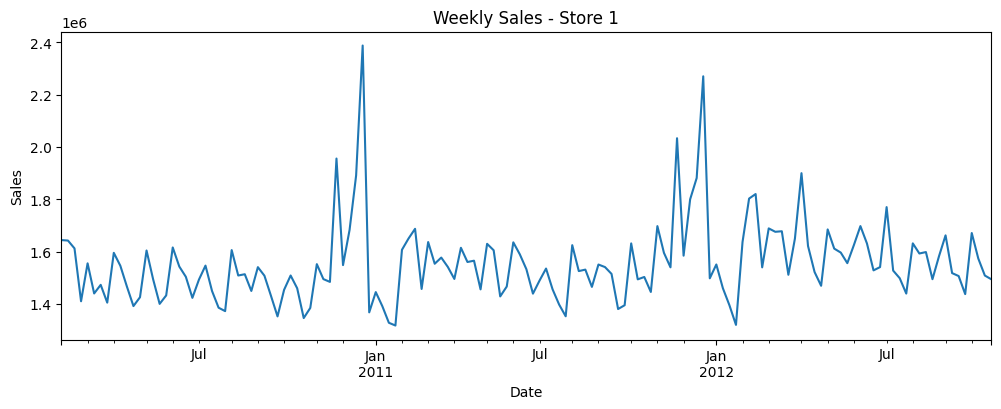

In [18]:
s1 = df[df['Store'] == 1].set_index('Date')

s1['Weekly_Sales'].plot(figsize=(12,4))
plt.title("Weekly Sales - Store 1")
plt.ylabel("Sales")
plt.show()


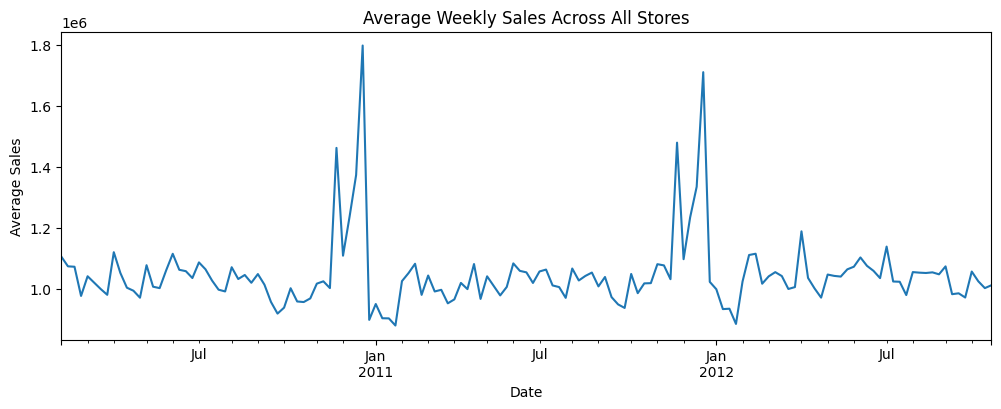

In [19]:
df = df.sort_values('Date')

avg_sales = df.groupby('Date')['Weekly_Sales'].mean()

plt.figure(figsize=(12,4))
avg_sales.plot()
plt.title("Average Weekly Sales Across All Stores")
plt.ylabel("Average Sales")
plt.xlabel("Date")
plt.show()


<Axes: xlabel='Month', ylabel='Weekly_Sales'>

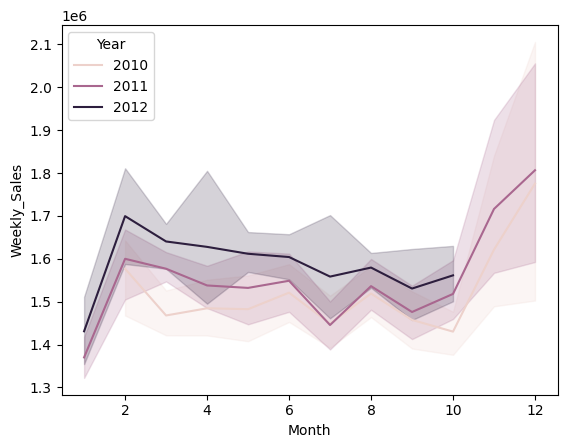

In [20]:
s1['Month'] = s1.index.month
s1['Year'] = s1.index.year

sns.lineplot(data=s1, x='Month', y='Weekly_Sales', hue='Year')


<Axes: xlabel='Month', ylabel='Year'>

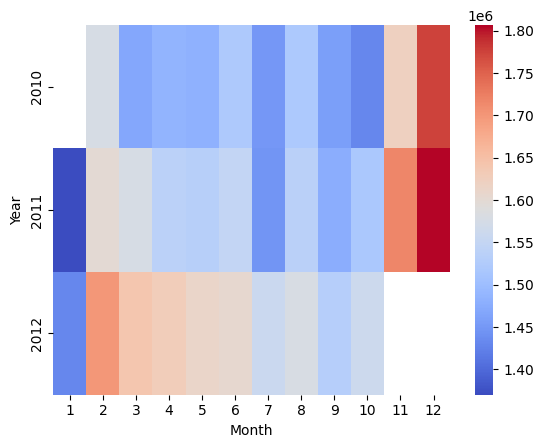

In [21]:
pivot = s1.pivot_table(values='Weekly_Sales', index='Year', columns='Month')
sns.heatmap(pivot, cmap="coolwarm")


<Axes: xlabel='Month', ylabel='Weekly_Sales'>

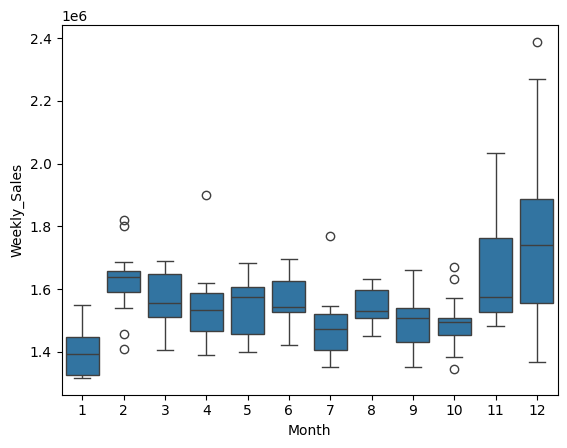

In [22]:
sns.boxplot(data=s1, x='Month', y='Weekly_Sales')


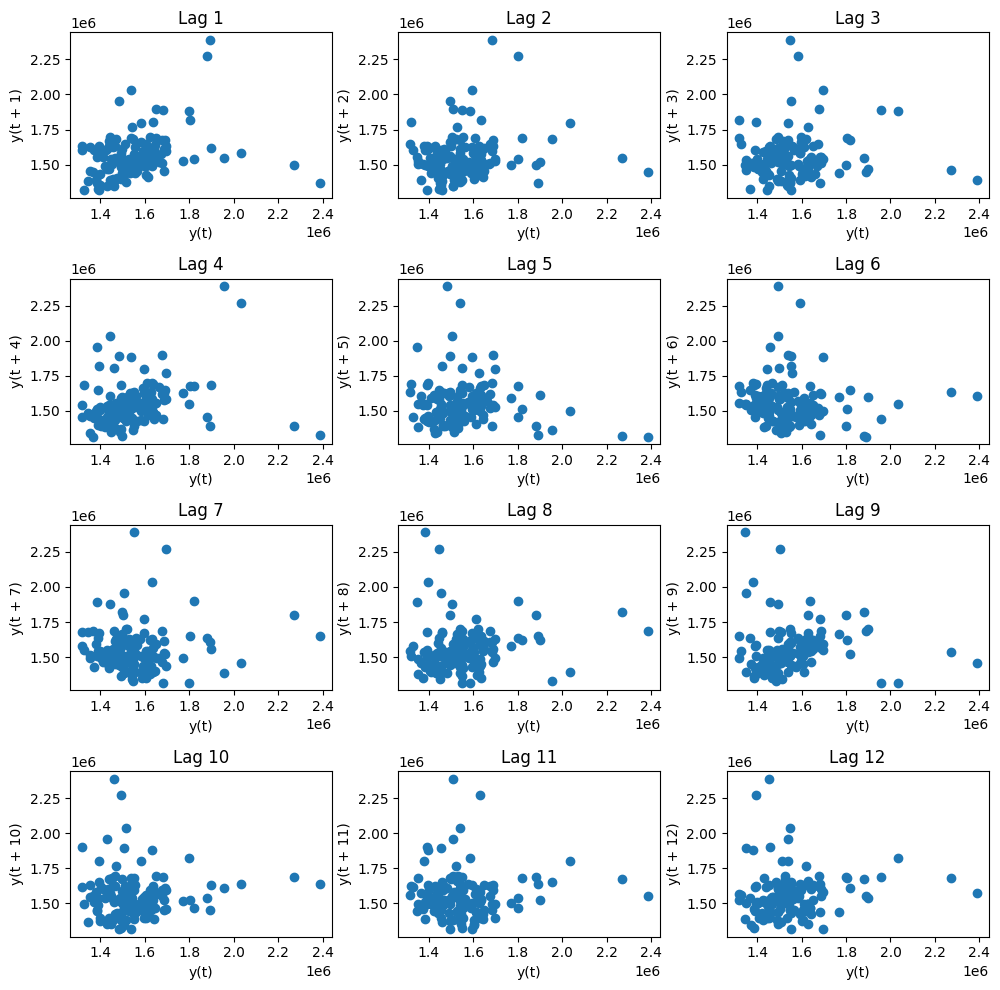

In [23]:
from pandas.plotting import lag_plot

plt.figure(figsize=(10,10))
for i in range(1,13):
    plt.subplot(4,3,i)
    lag_plot(s1['Weekly_Sales'], lag=i)
    plt.title(f"Lag {i}")
plt.tight_layout()
plt.show()


Review:

The line oscillates frequently around a baseline (~1.0M to 1.1M).
Week-to-week variation appears irregular and unpredictable.
Noise is high and comes from many random factors.

Seasonal effects (Expected): sharp peaks near late November / December, corresponding to: Black Friday,
Christmas shopping season

Slight dips mid-year (summer), Post-holiday declines (January troughs)

Trend (Weak or absent): Walmart weekly sales stay roughly stable around ~1.0–1.1M average, Show no long-term upward or downward drift, The dataset only covers ~3 years, too short for strong long-term trends



##### Decomposition / ACF

In [24]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

# Aggregate total sales across all stores per week
weekly = df.resample("W-MON", on="Date").agg(
    total_sales=("Weekly_Sales", "sum")
).ffill()

weekly.head()


,total_sales
Date,
2010-02-08,49750740.50
2010-02-15,48336677.63
2010-02-22,48276993.78
2010-03-01,43968571.13
2010-03-08,46871470.30


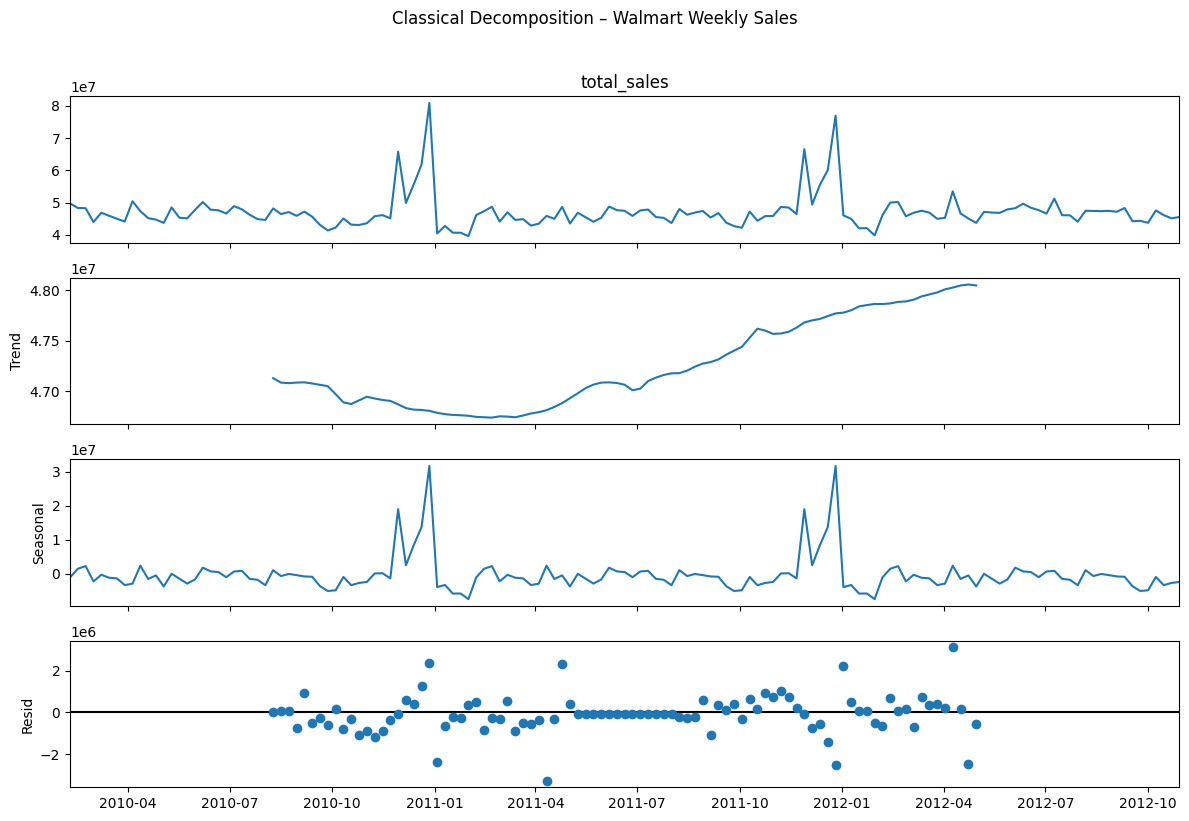

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

result = seasonal_decompose(weekly["total_sales"], model="additive", period=52)

fig = result.plot()
fig.set_size_inches(12, 8)
fig.suptitle("Classical Decomposition – Walmart Weekly Sales", y=1.02)
plt.tight_layout()
plt.show()


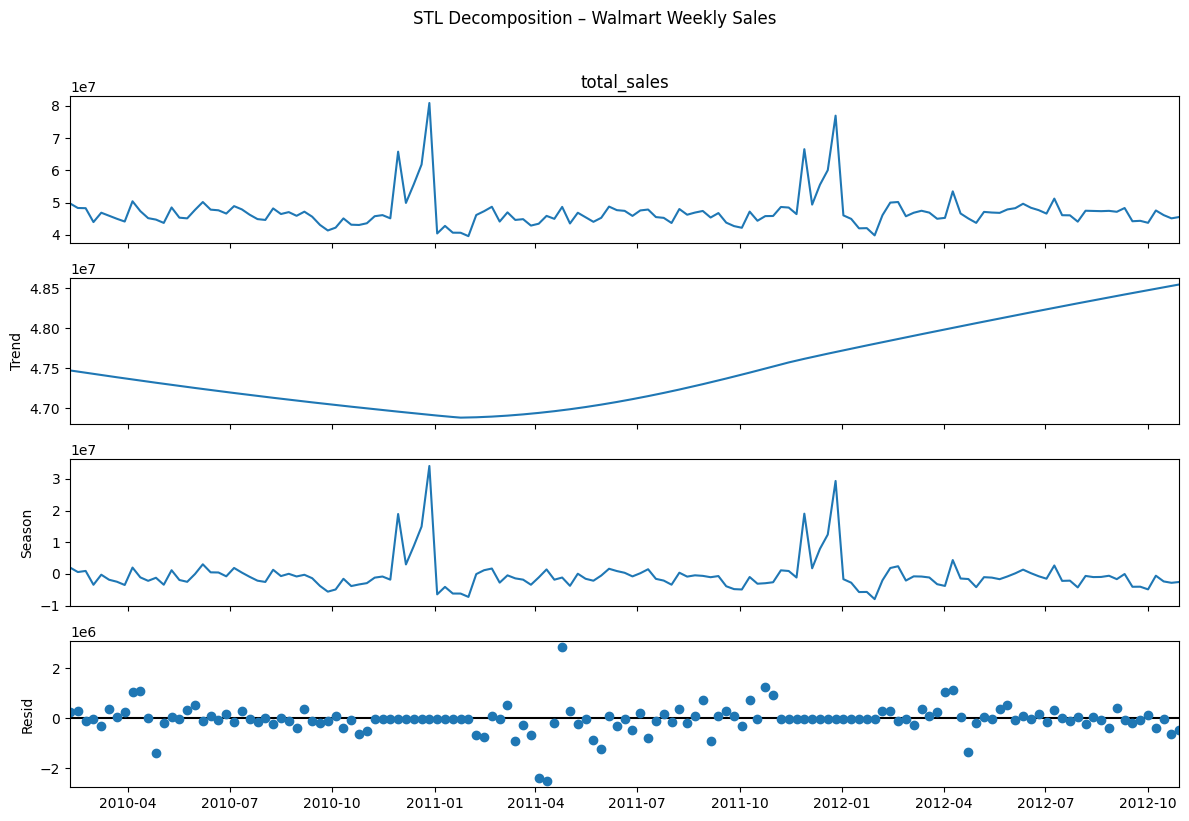

In [26]:
from statsmodels.tsa.seasonal import STL

stl = STL(weekly["total_sales"], period=52)
res = stl.fit()

fig = res.plot()
fig.set_size_inches(12, 8)
fig.suptitle("STL Decomposition – Walmart Weekly Sales", y=1.02)
plt.tight_layout()
plt.show()


The classical and STL decompositions of the Walmart weekly sales series show broadly similar insights but differ in smoothness. In both methods, we see clear seasonal spikes around major holidays and large residual deviations during those weeks. STL provides a smoother and more adaptive trend, capturing the gradual change in sales levels over time. STL also handles the extreme holiday spikes more robustly, producing cleaner residuals. Overall, STL offers a clearer separation of trend and seasonality.

<Figure size 1000x400 with 0 Axes>

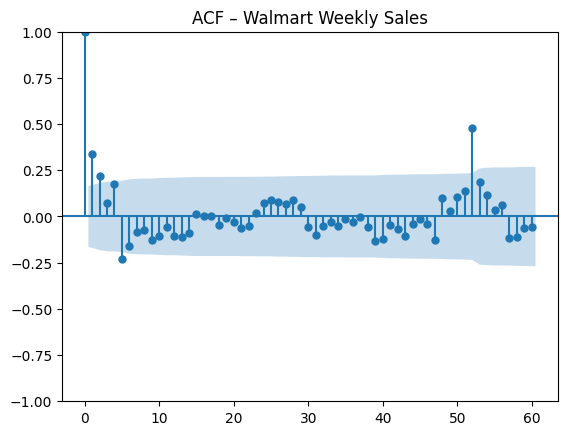

In [27]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10,4))
plot_acf(weekly["total_sales"], lags=60)
plt.title("ACF – Walmart Weekly Sales")
plt.show()


The ACF shows significant correlation at short lags (1–3 weeks), meaning weekly sales are strongly related to the previous few weeks. Small oscillating positive/negative correlations appear across medium lags, suggesting mild persistence but no strong long-term memory. The large spike around lag 52 indicates a clear annual seasonal pattern. Most other lags fall within the confidence band, meaning no additional strong seasonal cycles are present.

##### Stationary

Stationarity Test Results:
	- ADF: Stationary (p-value: 0.0000)
	- PP: Stationary (p-value: 0.0000)
	- KPSS: Non-Stationary (p-value: 0.0460)
	- ZA: Stationary (p-value: 0.0007)


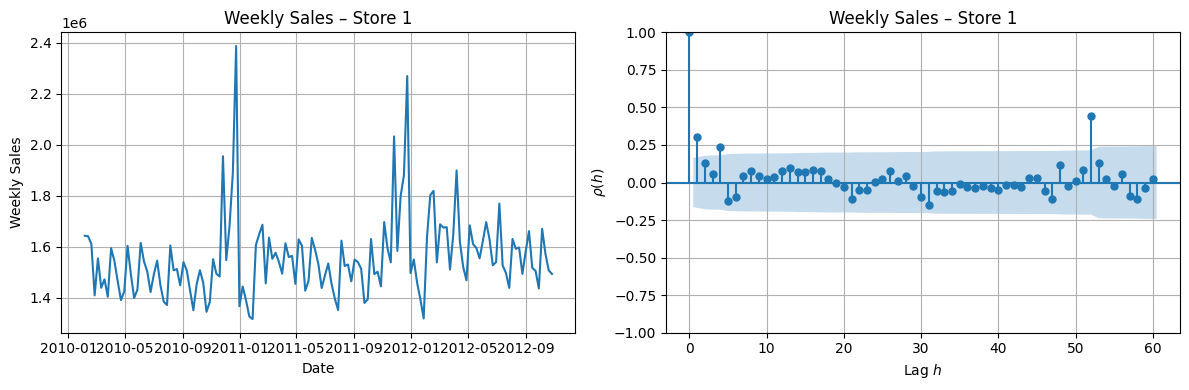

In [28]:
s1 = df[df['Store'] == 1].sort_values('Date')

data = s1.reset_index(drop=True)[['Date', 'Weekly_Sales']]

time_plot(
    x=data['Date'],
    y=data['Weekly_Sales'],
    title='Weekly Sales – Store 1',
    xlabel='Date',
    ylabel='Weekly Sales',
    with_acf=True,
    nlags=60,  
)

stationarity_tests(data['Weekly_Sales'])


ADF, PP, and ZA indicate that the series is stationary. KPSS suggests mild non-stationarity. -> weakly stationary

NameError: name 'y' is not defined

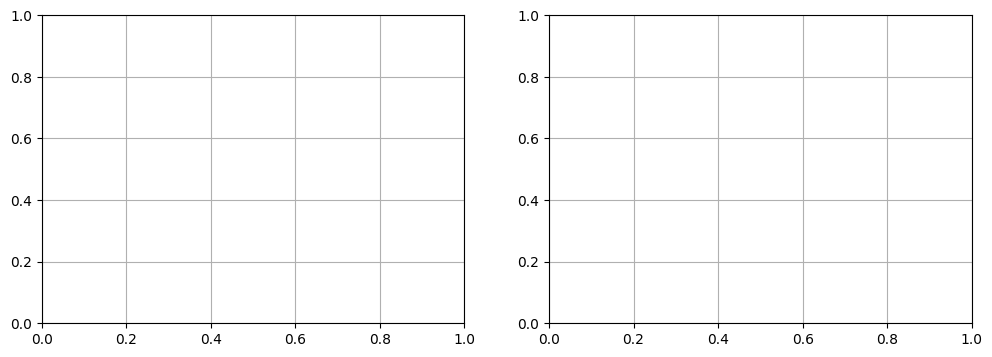

In [29]:
fig, (ax1, ax2) = get_figure(ncols=2)

# original
time_plot(
    x=y.index,
    y=y,
    title='Store 1 – Weekly Sales (original)',
    xlabel='Date',
    ylabel='Sales',
    ax=ax1,
)

# log-transform 
y_log = np.log(y)

time_plot(
    x=y_log.index,
    y=y_log,
    title='Store 1 – log(Weekly Sales)',
    xlabel='Date',
    ylabel='log(Sales)',
    ax=ax2,
)

fig.tight_layout()

print("Original series:")
stationarity_tests(y)

print("\nLog-transformed series:")
stationarity_tests(y_log)



Classical remainder:
Stationarity Test Results:
	- ADF: Stationary (p-value: 0.0000)
	- PP: Stationary (p-value: 0.0000)
	- KPSS: Stationary (p-value: 0.7686)
	- ZA: Stationary (p-value: 0.0000)

STL remainder:
Stationarity Test Results:
	- ADF: Stationary (p-value: 0.0212)
	- PP: Stationary (p-value: 0.0000)
	- KPSS: Stationary (p-value: 0.3813)
	- ZA: Non-Stationary (p-value: 0.0590)


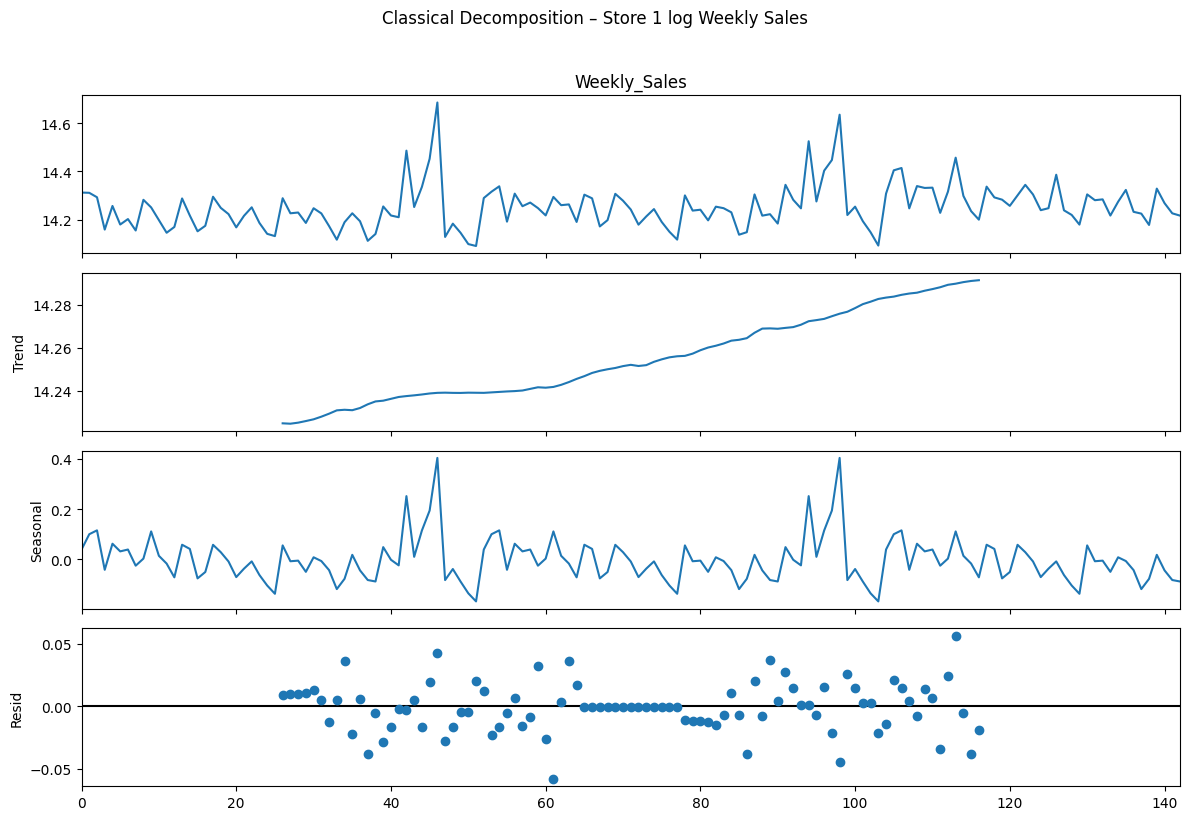

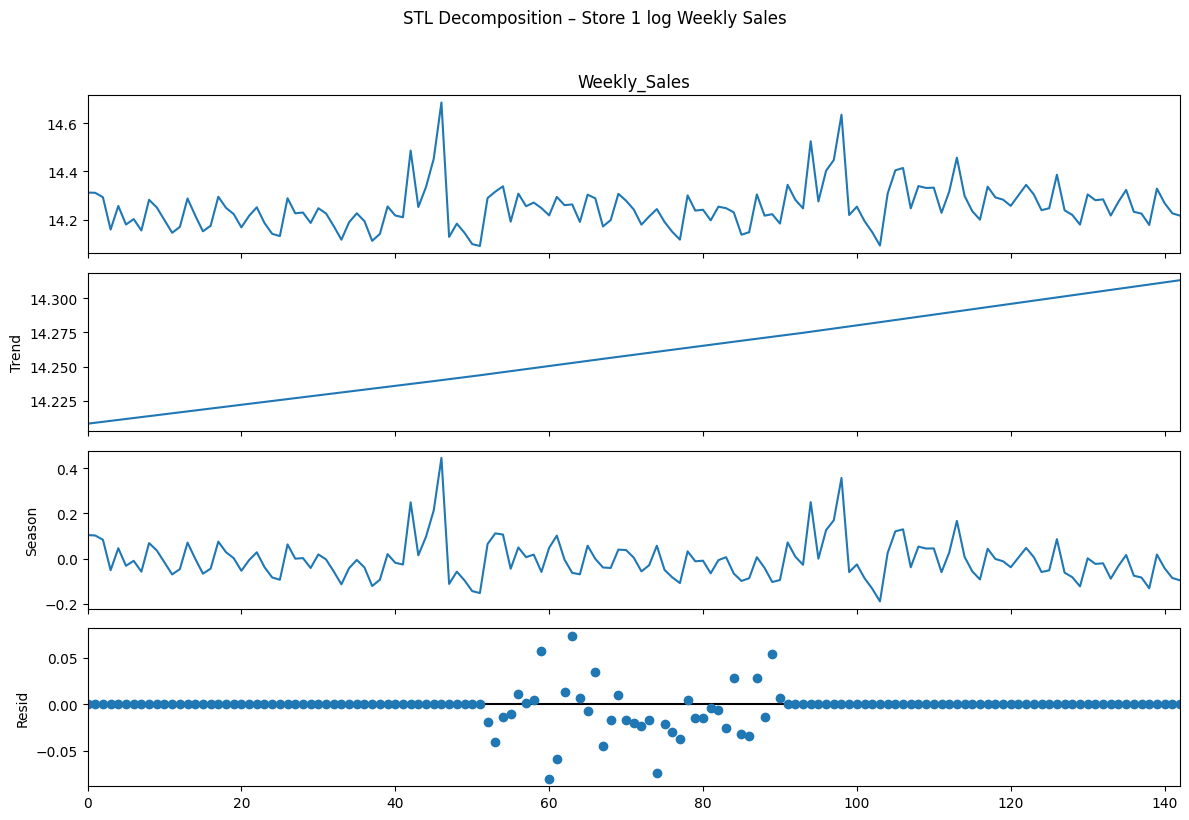

In [ ]:
from statsmodels.tsa.seasonal import STL, seasonal_decompose

# Classical decomposition 
res_class = seasonal_decompose(y_log, model='additive', period=52)

fig = res_class.plot()
fig.set_size_inches(12, 8)
fig.suptitle("Classical Decomposition – Store 1 log Weekly Sales", y=1.02)
fig.tight_layout()

# Take remainder as "de-trended & de-seasonalised" series
remainder_class = res_class.resid.dropna()
print("\nClassical remainder:")
stationarity_tests(remainder_class)

# STL decomposition 
res_stl = STL(y_log, period=52, robust=True).fit()

fig = res_stl.plot()
fig.set_size_inches(12, 8)
fig.suptitle("STL Decomposition – Store 1 log Weekly Sales", y=1.02)
fig.tight_layout()

remainder_stl = res_stl.resid.dropna()
print("\nSTL remainder:")
stationarity_tests(remainder_stl)


After decomposition, the remainders are more stationary. For the classical remainder, all tests agree on stationarity. For the STL remainder, most tests also indicate stationarity, with only a weak signal of structural change from the ZA test.

Removing trend and seasonality improves stationarity. The remaining non-stationarity seen before decomposition is largely explained by seasonal and trend components.

In [ ]:
y_seasdiff = y_log.diff(52).dropna()
print("\nSeasonally differenced (lag 52) log series:")
try:
    stationarity_tests(y_seasdiff)
except Exception as e:
    print("KPSS (or another test) failed:", e)



Seasonally differenced (lag 52) log series:
Stationarity Test Results:
	- ADF: Stationary (p-value: 0.0000)
	- PP: Stationary (p-value: 0.0000)
	- KPSS: Stationary (p-value: 0.0773)
	- ZA: Stationary (p-value: 0.0000)


After applying seasonal differencing (lag 52) to the log series, all tests now support stationarity. ADF, PP, and ZA strongly reject non-stationarity, and KPSS no longer rejects stationarity.

#### Coffe sales:

How was the data collected:
coffee shop transaction records

Dataset includes Hour of purchase (0–23), Mode of payment (cash / card), Transaction amount (in local currency), Type of coffee purchased, Categorized time of purchase (Morning, Afternoon, Night), Day of the week, Month of purchase, Date, Time

Which factors influence the data: time of day, weekday

Which patterns do you expect to find:

sale peaks on weekdays in the morning before work, 
more sales on the weekend during the day, 
favourite drink changes during the day, 



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

file_path = Path("../data/Coffe_sales.csv")


In [ ]:
df = pd.read_csv(file_path)

In [ ]:
print(df.head())

   hour_of_day cash_type  money    coffee_name Time_of_Day Weekday Month_name  \
0           10      card   38.7          Latte     Morning     Fri        Mar   
1           12      card   38.7  Hot Chocolate   Afternoon     Fri        Mar   
2           12      card   38.7  Hot Chocolate   Afternoon     Fri        Mar   
3           13      card   28.9      Americano   Afternoon     Fri        Mar   
4           13      card   38.7          Latte   Afternoon     Fri        Mar   

   Weekdaysort  Monthsort        Date             Time  
0            5          3  2024-03-01  10:15:50.520000  
1            5          3  2024-03-01  12:19:22.539000  
2            5          3  2024-03-01  12:20:18.089000  
3            5          3  2024-03-01  13:46:33.006000  
4            5          3  2024-03-01  13:48:14.626000  


In [ ]:
df["datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format="mixed",
    errors="coerce"
)

df = df.sort_values("datetime").set_index("datetime")
display(df.head())

,hour_of_day,cash_type,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time
datetime,,,,,,,,,,,
2024-03-01 10:15:50.520,10,card,38.7,Latte,Morning,Fri,Mar,5,3,2024-03-01,10:15:50.520000
2024-03-01 12:19:22.539,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:19:22.539000
2024-03-01 12:20:18.089,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:20:18.089000
2024-03-01 13:46:33.006,13,card,28.9,Americano,Afternoon,Fri,Mar,5,3,2024-03-01,13:46:33.006000
2024-03-01 13:48:14.626,13,card,38.7,Latte,Afternoon,Fri,Mar,5,3,2024-03-01,13:48:14.626000


In [ ]:
# check for missing values
print(df.isna().sum())

hour_of_day    0
cash_type      0
money          0
coffee_name    0
Time_of_Day    0
Weekday        0
Month_name     0
Weekdaysort    0
Monthsort      0
Date           0
Time           0
dtype: int64


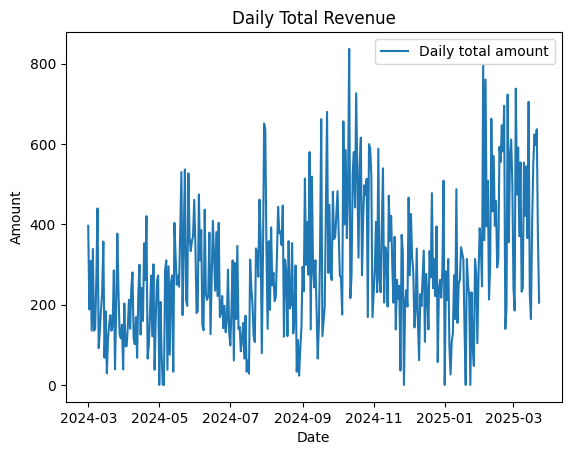

In [ ]:
# aggregate daily

daily = df.resample("D").agg(
    total_amount=("money", "sum"),
    n_transactions=("money", "count"),
    avg_amount=("money", "mean"),
)

fig, ax = plt.subplots()
ax.plot(daily.index, daily["total_amount"], label="Daily total amount")
ax.set_title("Daily Total Revenue")
ax.set_xlabel("Date")
ax.set_ylabel("Amount")
ax.legend()
plt.show()

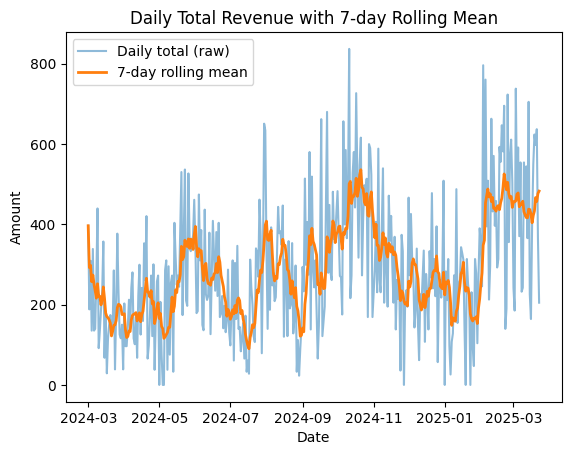

In [ ]:
# compute 7-day rolling mean

daily["total_amount_7d"] = daily["total_amount"].rolling(7, min_periods=1).mean()

fig, ax = plt.subplots()
ax.plot(daily.index, daily["total_amount"], label="Daily total (raw)", alpha=0.5)
ax.plot(daily.index, daily["total_amount_7d"], label="7-day rolling mean", linewidth=2)
ax.set_title("Daily Total Revenue with 7-day Rolling Mean")
ax.set_xlabel("Date")
ax.set_ylabel("Amount")
ax.legend()
plt.show()

Raw daily revenue is very noisy. Mid-year upward trend. End-of-year dip. Increase again in early next year.

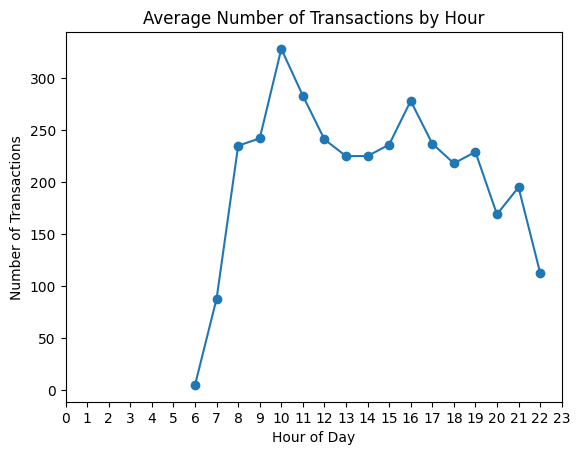

In [ ]:
hourly_pattern = df.groupby("hour_of_day")["money"].agg(
    avg_amount="mean",
    n_transactions="count",
)

fig, ax = plt.subplots()
ax.plot(hourly_pattern.index, hourly_pattern["n_transactions"], marker="o")
ax.set_title("Average Number of Transactions by Hour")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Number of Transactions")
plt.xticks(range(0, 24))
plt.show()

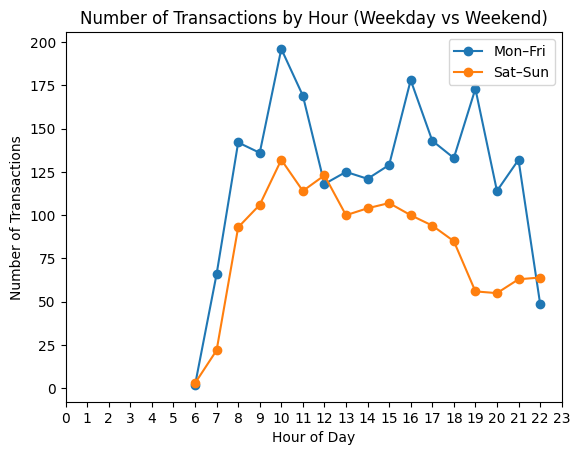

In [ ]:
# Define groups
weekday_df = df[df["Weekdaysort"] < 5]   # Mon–Fri
weekend_df = df[df["Weekdaysort"] >= 5]  # Sat–Sun

# Group by hour for each subset
weekday_hourly = weekday_df.groupby("hour_of_day")["money"].count()
weekend_hourly = weekend_df.groupby("hour_of_day")["money"].count()

# Plot
fig, ax = plt.subplots()
ax.plot(weekday_hourly.index, weekday_hourly.values,
        marker="o", label="Mon–Fri")

ax.plot(weekend_hourly.index, weekend_hourly.values,
        marker="o", label="Sat–Sun")

ax.set_title("Number of Transactions by Hour (Weekday vs Weekend)")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Number of Transactions")
plt.xticks(range(0, 24))
plt.legend()
plt.show()


On weekends, sales peak in the morning.
During the week, there are two peaks: one in the early morning before work and one in the late afternoon after work.
These patterns match normal customer routines during weekdays and weekends.

/var/folders/rs/65df6vr950918gkv11r91kmh0000gn/T/ipykernel_41261/2109203677.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dow_pattern = df.groupby("Weekday")["money"].agg(


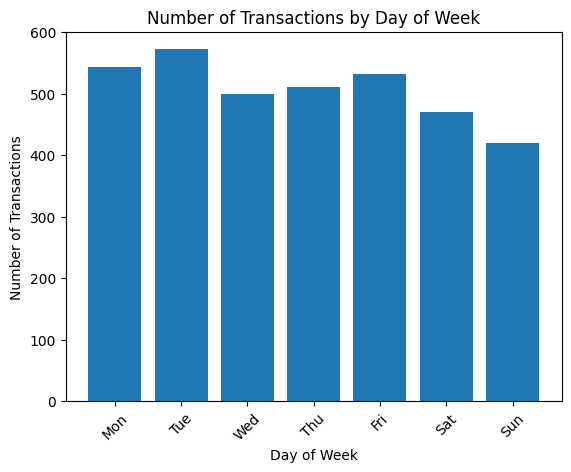

In [ ]:
dow_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
df["Weekday"] = pd.Categorical(df["Weekday"], categories=dow_order, ordered=True)

dow_pattern = df.groupby("Weekday")["money"].agg(
    avg_amount="mean",
    n_transactions="count",
)

fig, ax = plt.subplots()
ax.bar(dow_pattern.index, dow_pattern["n_transactions"])
ax.set_title("Number of Transactions by Day of Week")
ax.set_xlabel("Day of Week")
ax.set_ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.show()


Outlier days based on daily total amount (IQR rule):


,total_amount,n_transactions,avg_amount,total_amount_7d
datetime,,,,
2024-10-11,836.66,26,32.179231,500.834286
2024-10-17,726.46,21,34.593333,514.551429
2025-02-03,796.00,25,31.840000,347.860000
2025-02-05,760.24,24,31.676667,453.457143
2025-02-21,695.08,23,30.220870,525.320000
2025-02-24,723.02,22,32.864545,504.468571
2025-03-03,737.72,22,33.532727,458.074286
2025-03-14,704.88,23,30.646957,437.640000


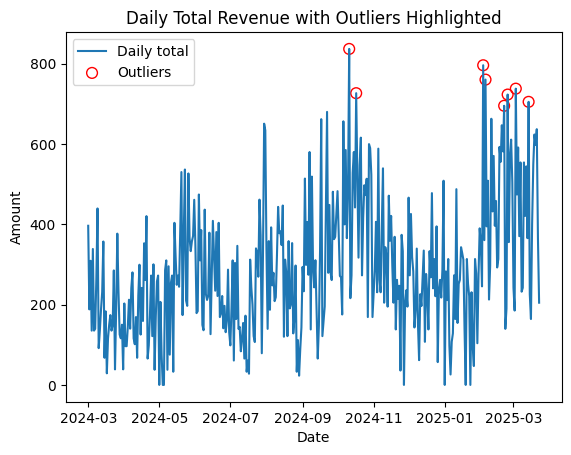

In [ ]:
# Use IQR on daily total_amount
Q1 = daily["total_amount"].quantile(0.25)
Q3 = daily["total_amount"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = daily[(daily["total_amount"] < lower_bound) | (daily["total_amount"] > upper_bound)]

print("\nOutlier days based on daily total amount (IQR rule):")
display(outliers)

# Plot daily with outliers highlighted
fig, ax = plt.subplots()
ax.plot(daily.index, daily["total_amount"], label="Daily total")
ax.scatter(
    outliers.index,
    outliers["total_amount"],
    s=60,
    marker="o",
    edgecolors="red",
    facecolors="none",
    label="Outliers",
)
ax.set_title("Daily Total Revenue with Outliers Highlighted")
ax.set_xlabel("Date")
ax.set_ylabel("Amount")
ax.legend()
plt.show()


The daily series is extremely irregular. It does not follow a consistent pattern.
Noise dominates the deterministic signal.

#### Air Quality Data Set

How was the data collected:
The dataset consists of “hourly averaged responses” from an array of five metal-oxide chemical sensors. 

Which factors influence the data: 
Seasonality and seasonal weather cycles (winter: cold -> heating) |  
Pollutants come from sources like traffic, industrial emissions, heating. |  
Meteorological conditions: Temperature, humidity, atmospheric pressure, wind. |
The amount and pattern of those emissions depend on urbanization, population, economic activity

Wich patterns do you expect to find:
Seasonal cycles: Higher pollutant concentrations in winter  |
daily cycles: Pollution might peak during rush-hours  |
Long-term upward trend
Weekday vs weekend differences: Maybe lower pollution on weekends if commuter/industrial traffic drops.

In [ ]:
df = pd.read_csv("../data/AirQuality.csv", sep=";", decimal=",", na_values=[-200],)

In [ ]:
df = df.dropna(axis=1, how="all")
print(df.head())
print(df.columns)

         Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
1  10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
2  10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   
3  10/03/2004  21.00.00     2.2       1376.0      80.0       9.2   
4  10/03/2004  22.00.00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   

      T    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502  
3  11.0  60.0  0.786

In [ ]:
df["datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format="%d/%m/%Y %H.%M.%S"
)

df = df.set_index("datetime").sort_index()


In [ ]:
series = df["C6H6(GT)"].astype(float)
series = series.dropna()


In [ ]:
s = series.resample("H").mean()
s = s.interpolate()   # needed for STL


/var/folders/rs/65df6vr950918gkv11r91kmh0000gn/T/ipykernel_41261/1996573283.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s = series.resample("H").mean()


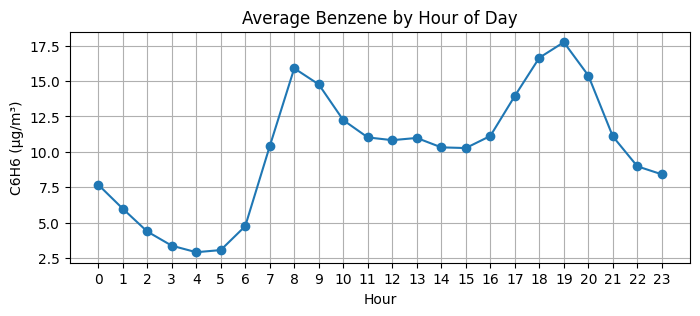

In [ ]:
df["hour"] = df.index.hour
df["C6H6"] = df["C6H6(GT)"]

hourly_pattern = df.groupby("hour")["C6H6"].mean()

plt.figure(figsize=(8,3))
plt.plot(hourly_pattern.index, hourly_pattern.values, marker="o")
plt.title("Average Benzene by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("C6H6 (μg/m³)")
plt.grid(True)
plt.xticks(range(24))
plt.show()


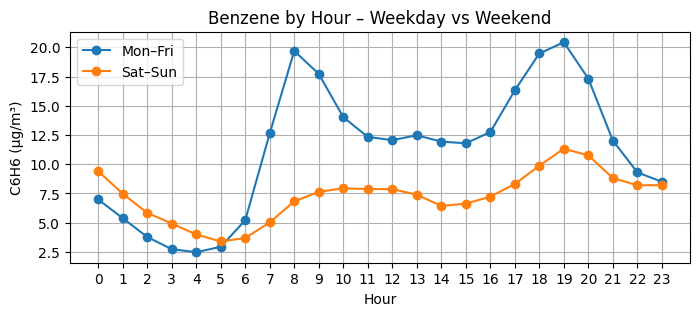

In [ ]:
df["weekday"] = df.index.weekday

weekday_df = df[df["weekday"] < 5]
weekend_df = df[df["weekday"] >= 5]

weekday_hourly = weekday_df.groupby("hour")["C6H6"].mean()
weekend_hourly = weekend_df.groupby("hour")["C6H6"].mean()

plt.figure(figsize=(8,3))
plt.plot(weekday_hourly.index, weekday_hourly, marker="o", label="Mon–Fri")
plt.plot(weekend_hourly.index, weekend_hourly, marker="o", label="Sat–Sun")
plt.title("Benzene by Hour – Weekday vs Weekend")
plt.xlabel("Hour")
plt.ylabel("C6H6 (μg/m³)")
plt.legend()
plt.grid(True)
plt.xticks(range(24))
plt.show()


In [ ]:
Q1 = s.quantile(0.25)
Q3 = s.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = s[(s < lower) | (s > upper)]
print(outliers.head())


datetime
2004-03-12 20:00:00    32.6
2004-03-15 09:00:00    36.7
2004-03-15 18:00:00    32.1
2004-03-15 19:00:00    39.2
2004-03-15 20:00:00    31.0
Name: C6H6(GT), dtype: float64


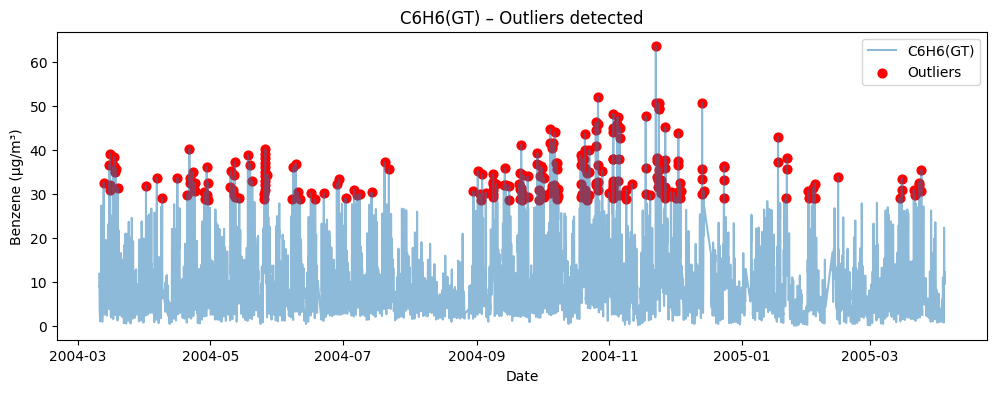

In [ ]:

plt.figure(figsize=(12,4))

# Plot the original hourly benzene series
plt.plot(s.index, s.values, label="C6H6(GT)", alpha=0.5)

# Plot the outliers as red circles
plt.scatter(
    outliers.index,
    s.loc[outliers.index],
    color="red",
    s=40,
    label="Outliers"
)

plt.title("C6H6(GT) – Outliers detected")
plt.xlabel("Date")
plt.ylabel("Benzene (μg/m³)")
plt.legend()
plt.show()


Very clear diurnal cycle with benzene concentrations: Lowest values (2–4 µg/m³) around 3–6 AM, when traffic is minimal. A sharp rise around 7–9 AM (morning traffic). A second peak around 18–20 PM (evening commute). A drop again late at night.

Conclusion on noise: Raw hourly data is noisy, but averaging by hour smooths much of it.

Do the patterns match expectations given the DGP?
Yes, my expectations were: Morning peaks due to traffic -> Confirmed. plots show a strong morning spike on weekdays (8–9 AM). Weekends have a smaller version of the same effect.
This matches real-world: People driving to work → benzene increases from vehicle exhaust. Weekends have later, softer peaks.

Weekday vs weekend behavior -> strongly confirmed. Weekdays have bigger peaks (morning + evening).
Weekends show later, flatter peaks, consistent with leisure traffic.

Outliers likely correspond to:

Short-term pollution events (Heavy traffic congestion, Road closures/diversions, Accidents or construction work)
Meteorological conditions (Temperature inversion — Cold air trapped near ground → pollution can’t disperse → spikes. Low wind / calm weather — Pollutants accumulate near sensor.)


##### Decomposition / ACF

In [ ]:
s = df["C6H6(GT)"]

# Resample hourly → daily mean (much cleaner for decomposition)
daily = s.resample("D").mean().ffill()

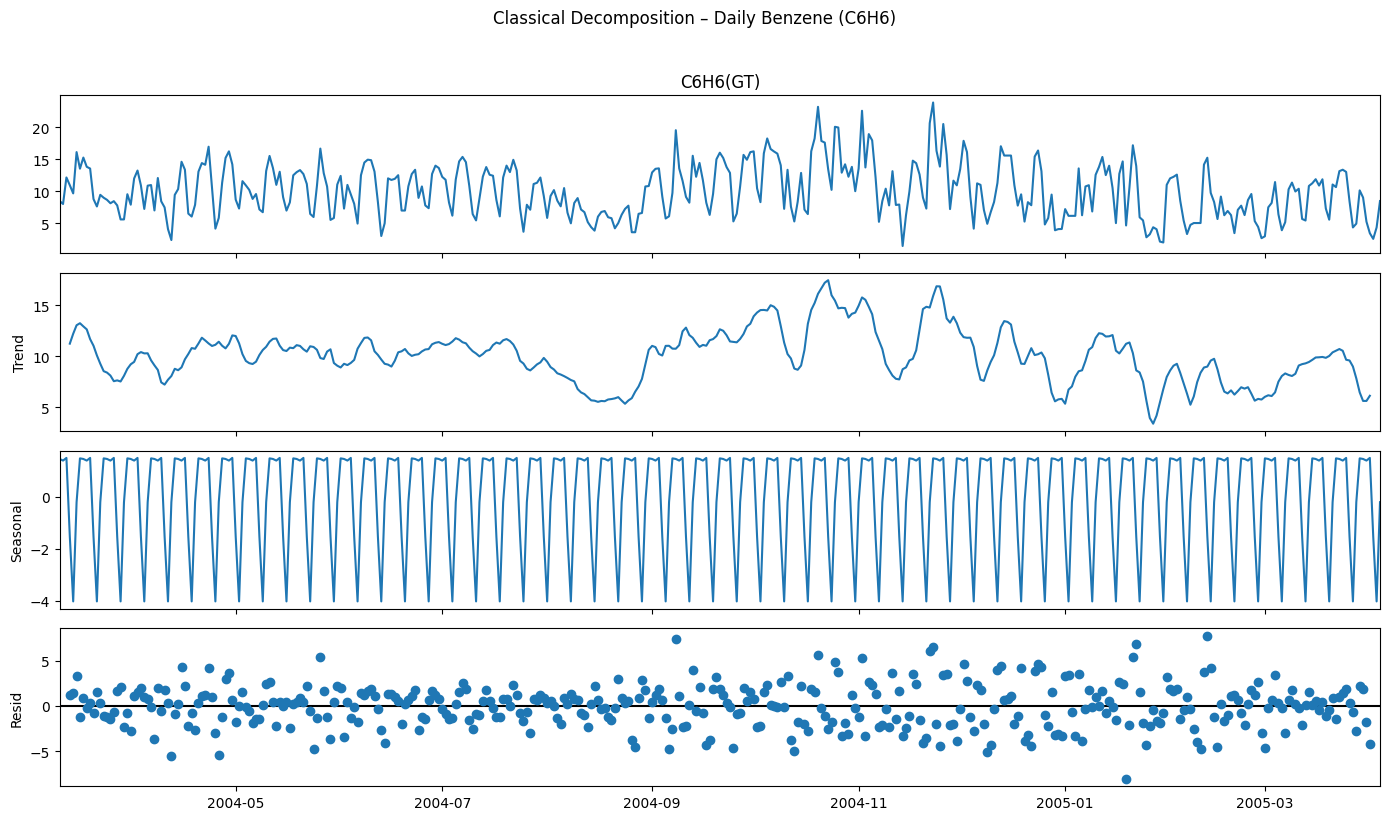

In [ ]:
res_classical = seasonal_decompose(daily, model="additive", period=7)

fig = res_classical.plot()
fig.set_size_inches(14, 8)
fig.suptitle("Classical Decomposition – Daily Benzene (C6H6)", y=1.02)
plt.tight_layout()
plt.show()

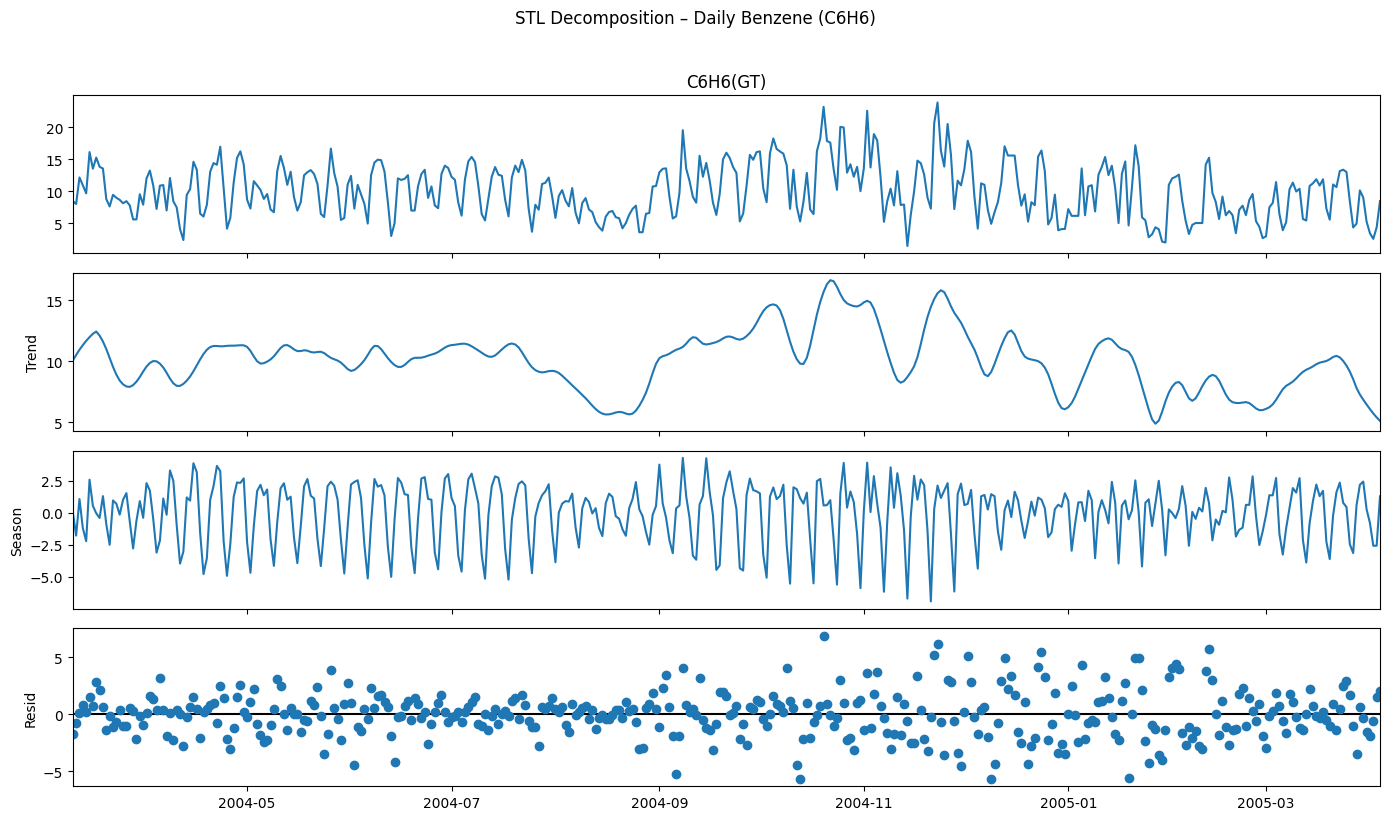

In [ ]:
res_stl = STL(daily, period=7).fit()

fig = res_stl.plot()
fig.set_size_inches(14, 8)
fig.suptitle("STL Decomposition – Daily Benzene (C6H6)", y=1.02)
plt.tight_layout()
plt.show()

The classical decomposition shows a very regular and almost perfectly repeating seasonal pattern, because it assumes that the seasonal effect is fixed and does not change over time. In contrast, the STL decomposition reveals that the seasonal pattern varies in shape and intensity across the year, which is more realistic for air-quality data influenced by weather and human activity. STL also produces a smoother and more stable trend component, while the classical trend looks noisier. Overall, STL captures the changing seasonality and underlying structure of the benzene data more accurately.

<Figure size 800x500 with 0 Axes>

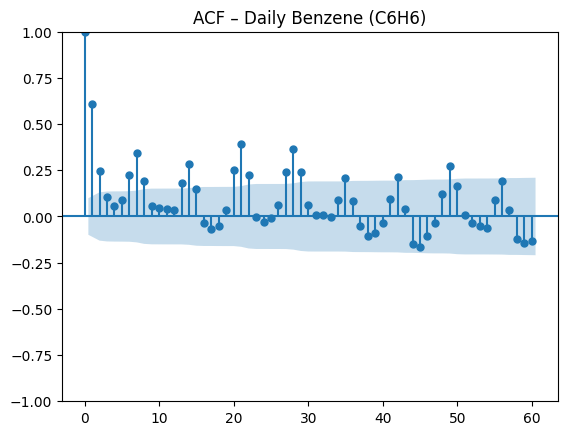

In [ ]:
plt.figure(figsize=(8, 5))
plot_acf(daily, lags=60)
plt.title("ACF – Daily Benzene (C6H6)")
plt.show()

The ACF shows strong autocorrelation at lag 1, meaning today’s benzene level is highly related to yesterday’s. After that, autocorrelations decay gradually, indicating a persistent but weakening memory in the series. Several mid-range lags (e.g., around lags 7, 14, 21, 30) appear slightly above significance, suggesting weekly repeating effects, likely driven by weekday–weekend emission patterns. 

#### Stationary

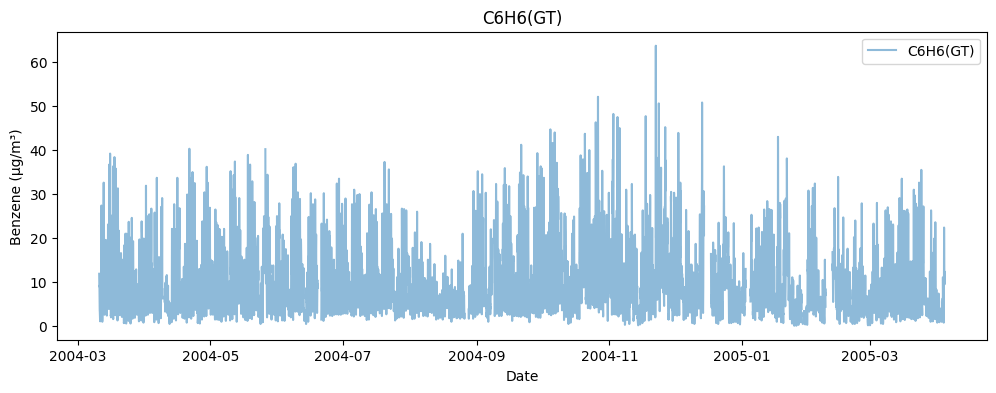

In [ ]:
plt.figure(figsize=(12,4))

plt.plot(s.index, s.values, label="C6H6(GT)", alpha=0.5)

plt.title("C6H6(GT)")
plt.xlabel("Date")
plt.ylabel("Benzene (μg/m³)")
plt.legend()
plt.show()


Stationarity Test Results:
	- ADF: Stationary (p-value: 0.0000)
	- PP: Stationary (p-value: 0.0000)
	- KPSS: Non-Stationary (p-value: 0.0066)
	- ZA: Stationary (p-value: 0.0000)


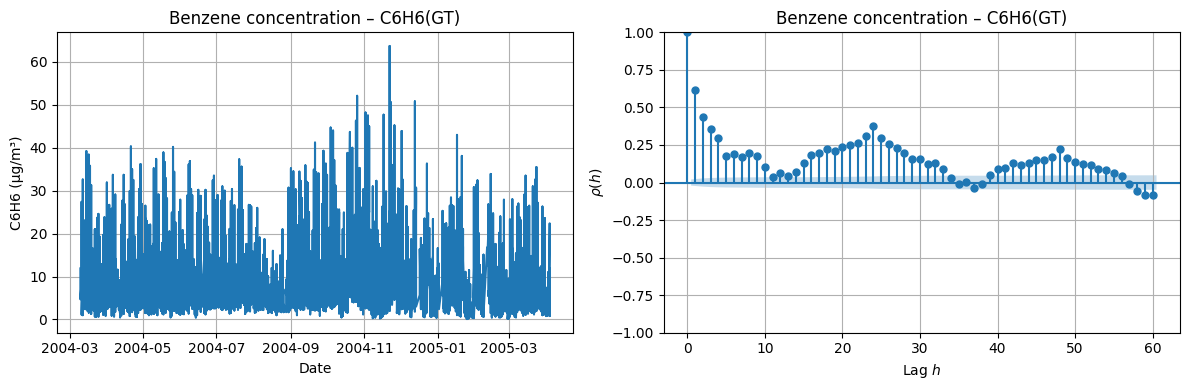

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')

s = df[['Date', 'C6H6(GT)']].dropna()

data = s.reset_index(drop=True)[['Date', 'C6H6(GT)']]

time_plot(
    x=data['Date'],
    y=data['C6H6(GT)'],
    title='Benzene concentration – C6H6(GT)',
    xlabel='Date',
    ylabel='C6H6 (µg/m³)',
    with_acf=True,
    nlags=60,
)

stationarity_tests(data['C6H6(GT)'])


The ADF, PP, and ZA tests all indicate that the series is stationary. The KPSS test rejects stationarity with a low p-value (0.0066). -> weakly stationary


Stationarity Test Results:
	- ADF: Stationary (p-value: 0.0000)
	- PP: Stationary (p-value: 0.0000)
	- KPSS: Non-Stationary (p-value: 0.0001)
	- ZA: Stationary (p-value: 0.0000)


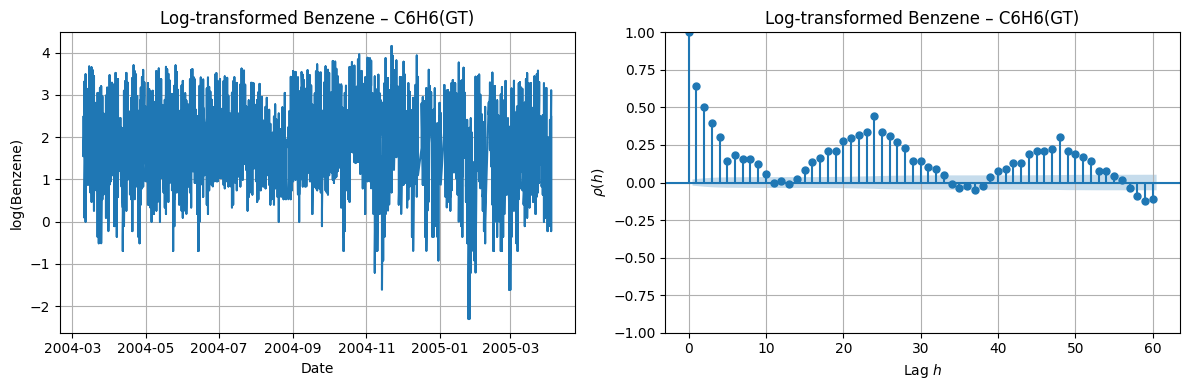

In [ ]:
# Log-transform just the benzene values
data['C6H6(GT)_log'] = np.log(data['C6H6(GT)'])


# Plot + stationarity tests on the log series
time_plot(
    x=data['Date'],
    y=data['C6H6(GT)_log'],
    title='Log-transformed Benzene – C6H6(GT)',
    xlabel='Date',
    ylabel='log(Benzene)',
    with_acf=True,
    nlags=60,
)

stationarity_tests(data['C6H6(GT)_log'].dropna())

The log transformation did not improve stationarity. After the log transform, KPSS still rejects stationarity.

In [ ]:
# Parse dates and sort
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')

# Keep only the benzene series as a numeric 1D series with Date index
s = df.set_index('Date')['C6H6(GT)'].dropna().astype(float)

# STL decomposition with daily cycle (24 hours)
from statsmodels.tsa.seasonal import STL

stl = STL(s, period=24).fit()
trend = stl.trend
seasonal = stl.seasonal
resid = stl.resid

stationarity_tests(resid.dropna())


Stationarity Test Results:
	- ADF: Stationary (p-value: 0.0000)
	- PP: Stationary (p-value: 0.0000)
	- KPSS: Stationary (p-value: 0.9986)
	- ZA: Stationary (p-value: 0.0000)


After applying STL decomposition with a daily cycle (24 hours) and taking the residuals, all stationarity tests now agree. ADF, PP, KPSS, and ZA all indicate that the series is stationary. This shows that the main sources of non-stationarity were trend and daily seasonality.

Original series:
Stationarity Test Results:
	- ADF: Stationary (p-value: 0.0000)
	- PP: Stationary (p-value: 0.0000)
	- KPSS: Non-Stationary (p-value: 0.0109)
	- ZA: Stationary (p-value: 0.0000)

After 1st differencing:
Stationarity Test Results:
	- ADF: Stationary (p-value: 0.0000)
	- PP: Stationary (p-value: 0.0000)
	- KPSS: Stationary (p-value: 0.9964)
	- ZA: Stationary (p-value: 0.0000)


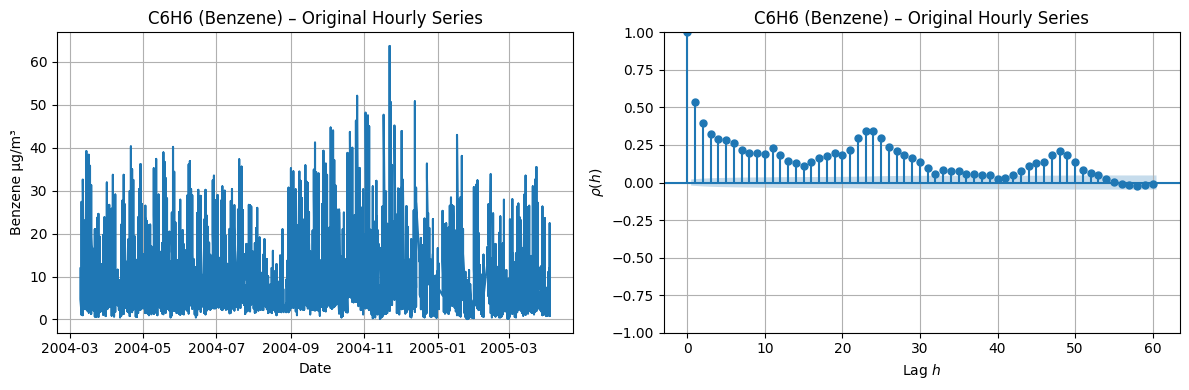

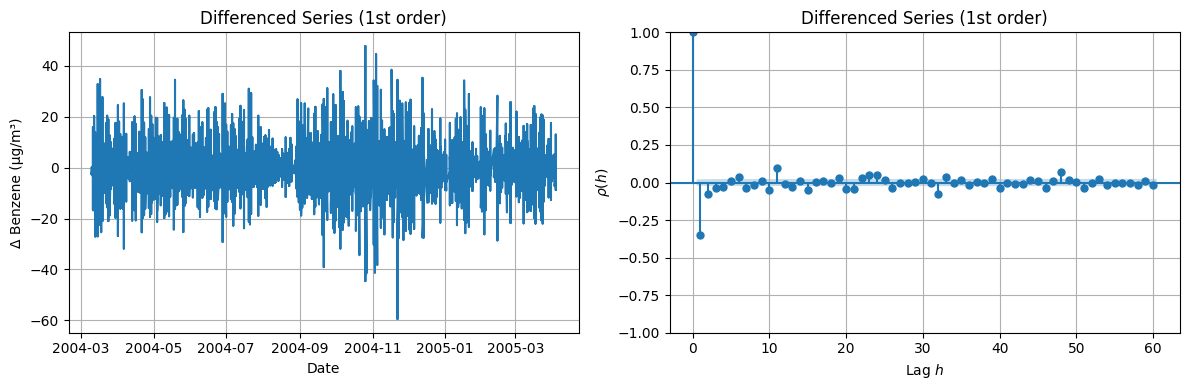

In [ ]:
# --- PREPARE DATA ---------------------------------------------------------

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')

# Rename the sensor column if needed
# Many AirQuality CSVs use "C6H6(GT)" → your df probably renamed it automatically
benzene_col = [c for c in df.columns if "C6H6" in c][0]

# Extract numeric benzene series
s = df[['Date', benzene_col]].dropna()
s = s.set_index('Date')[benzene_col].astype(float)

#  original (Hourly) 

time_plot(
    x=s.index,
    y=s.values,
    title='C6H6 (Benzene) – Original Hourly Series',
    xlabel='Date',
    ylabel='Benzene μg/m³',
    with_acf=True,
    nlags=60,
)

print("Original series:")
stationarity_tests(s.dropna())

# first differencing

s_diff1 = s.diff().dropna()

time_plot(
    x=s_diff1.index,
    y=s_diff1.values,
    title='Differenced Series (1st order)',
    xlabel='Date',
    ylabel='Δ Benzene (μg/m³)',
    with_acf=True,
    nlags=60,
)

print("\nAfter 1st differencing:")
stationarity_tests(s_diff1)


First differencing successfully removes the remaining non-stationarity in the original series and produces a clearly stationary series.